In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_location = '/home/marcin/Datasets/udacity-challange-flower-data/flower_data/'

# Baseline with DataLoaders

In [4]:
# transforms_list = transforms.Compose([
#     transforms.Resize(256),
#     transforms.Pad(100, padding_mode='reflect'),
#     transforms.RandomRotation(45),
#     transforms.CenterCrop(256),
#     transforms.RandomResizedCrop(224, scale=(0.8 , 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])
transforms_list = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [5]:
dataset_train = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_list)
dataset_valid = datasets.ImageFolder(os.path.join(dataset_location, 'valid'), transforms_list)
print('Number of train images:', len(dataset_train))
print('Number of valid images:', len(dataset_valid))

Number of train images: 6552
Number of valid images: 818


In [33]:
enable_shuffle = True
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=enable_shuffle,
                                               num_workers=6, pin_memory=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16, shuffle=enable_shuffle,
                                               num_workers=6, pin_memory=True)

In [41]:
model = models.densenet121(pretrained=True)

# Freeze feature paremeters
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier

model = model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

Helper

In [42]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

Train model

In [43]:
num_epochs = 20
batch_size = 64

since = time.time()

hist = { 'tepoch':[], 'tloss':[], 'tacc':[],  # mini-batch loss/acc every iteration
         'vepoch':[], 'vloss':[], 'vacc':[],
         'train_loss':[], 'train_acc':[],     # train set loss/acc every epoch
         'valid_loss':[], 'valid_acc':[] }        # valid set loss/acc every epoch

for epoch in range(num_epochs):
    
    epoch_time_start = time.time()
    
    ### Train ###
    model.train()
    for images, labels in dataloader_train:
        
        # Push to GPU
        x = images.to(device)
        y = labels.to(device)
        
        # Optimize
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Record per-iteration stats
        with torch.no_grad():
            acc = accuracy(outputs, y)
            hist['tepoch'].append( epoch )
            hist['tacc'].append( acc.item() )
            hist['tloss'].append( loss.item() )
            
    
    ### Evaluate ###
    model.eval()
    loss_sum = 0
    acc_sum = 0
    for images, labels in dataloader_valid:
        
        # Push to GPU
        x = images.to(device)
        y = labels.to(device)
        
        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            acc = accuracy(outputs, y)
            loss_sum += loss.item() * len(images)
            acc_sum += acc.item() * len(images)
            hist['vepoch'].append( epoch )
            hist['vloss'].append( loss.item() )
            hist['vacc'].append( acc.item() )
    
    hist['valid_loss'].append( loss_sum / len(dataset_valid) )
    hist['valid_acc'].append( acc_sum / len(dataset_valid) )
    
    epoch_time_interval = time.time() - epoch_time_start
    
    ### Print Summary ###
    if epoch == 0:
        print('      (time )   ep             loss / acc                loss / acc')
    print(f'Epoch ({epoch_time_interval:4.2f}s): {epoch:3}'
          # f'    Train: {hist["train_loss"][-1]:6.4f} / {hist["train_acc"][-1]:6.4f}'
          f'    Valid: {hist["valid_loss"][-1]:6.4f} / {hist["valid_acc"][-1]:6.4f}')
        
            
print(time.time() - since)

      (time )   ep             loss / acc                loss / acc
Epoch (24.44s):   0    Valid: 0.9022 / 0.7751
Epoch (24.54s):   1    Valid: 0.4585 / 0.8863
Epoch (25.34s):   2    Valid: 0.3507 / 0.9169
Epoch (24.64s):   3    Valid: 0.3218 / 0.9156
Epoch (24.78s):   4    Valid: 0.3258 / 0.9046


KeyboardInterrupt: 

In [37]:
def pretty_plot(ax, data, label, color, alpha=1.0):
    def smooth(y, n):
        return np.convolve(y, v=np.ones(n)/n, mode='same')
    ax.scatter(range(len(data)), data, marker='.', s=2, color=color)
    ax.plot(smooth(data, 20), label=label, color=color)

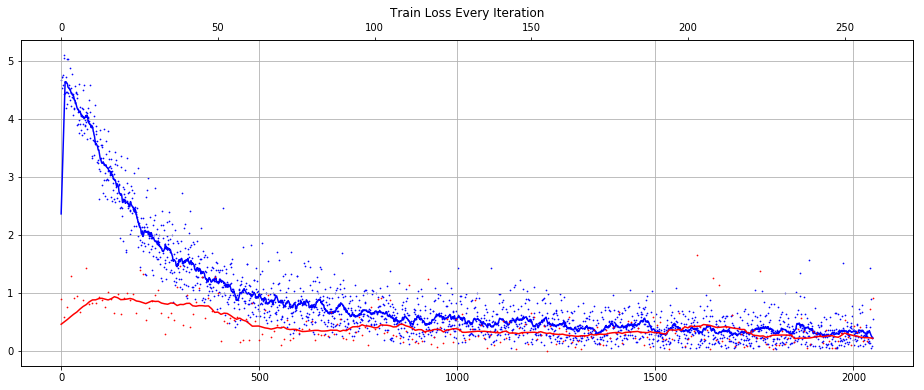

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,6])
pretty_plot(ax, hist['tloss'], 'tloss', 'blue')
pretty_plot(ax.twiny(), hist['vloss'], 'vloss', 'red')
ax.set_title('Train Loss Every Iteration');
ax.grid();

In [39]:
def plot_hist(hist, title):
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,3])
     
    fig.suptitle(title, fontsize=16)
    
    #ax.plot(hist['train_loss'], label='train_loss', color='blue')
    pretty_plot(ax.twiny(), hist['tloss'], 'tloss', color='blue', alpha=.5)
    ax.plot(hist['valid_loss'], label='valid_loss', color='orange')
    ax.set_title('Loss'); ax.legend(); ax.grid(); ax.set_ylim([0, 1]);
    
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,3])
    ax2.plot(hist['train_acc'], label='train_acc', color='blue')
    #pretty_plot(ax2.twiny(), hist['tacc'], 'tacc', color='blue', alpha=1)
    ax2.plot(hist['valid_acc'], label='valid_acc', color='orange')
    ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(); ax2.set_ylim([.8, 1]);
    
    plt.tight_layout()

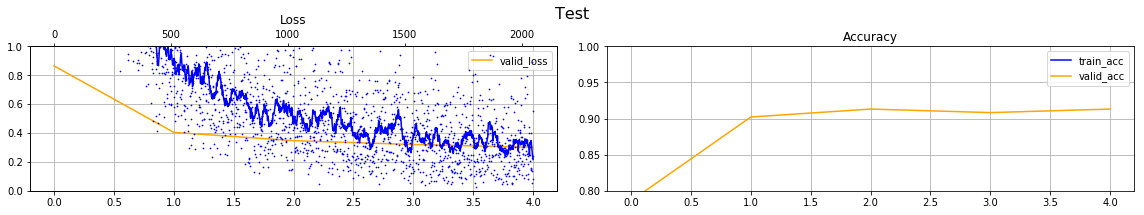

In [40]:
plot_hist(hist, title='Test')

# Oxford VGG Flowers - Udacity Challange

Create transforms

In [ ]:
transforms_normal = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [ ]:
transforms_augmented = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.08 , 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [ ]:
dataset_train_normal = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_normal)
dataset_valid_normal = datasets.ImageFolder(os.path.join(dataset_location, 'valid'), transforms_normal)
print('Number of train images:', len(dataset_train_normal))
print('Number of validation images:', len(dataset_valid_normal))

In [ ]:
dataset_train_augmented = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_augmented)

Create two dataloaders for now

In [ ]:
dataloader_train_normal = torch.utils.data.DataLoader(dataset_train_normal, batch_size=16, shuffle=False,
                                                     num_workers=6, pin_memory=True)
dataloader_valid_normal = torch.utils.data.DataLoader(dataset_valid_normal, batch_size=16, shuffle=False,
                                                     num_workers=6, pin_memory=True)

# Precompute features

In [75]:
class Passthrough(torch.nn.Module):
    def forward(self, input):
        return input

In [76]:
model_cnn = models.densenet121(pretrained=True)

# disable all gradients
for param in model_cnn.parameters():
    param.requires_grad = False

model_cnn.classifier = Passthrough()
model_cnn.to(device);

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [81]:
def extract_features(model_cnn, dataloader):
    """
    Params:
        model_cnn - big convnet with final dense layers removed
        dataloader - we get data from here
    """
    features_list = []
    labels_list = []
    
    model_cnn.eval()
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model_cnn(images)
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.numpy())

    features_arr = np.concatenate(features_list)
    labels_arr = np.concatenate(labels_list)

    return features_arr, labels_arr

In [86]:
train_features_normal, train_labels_normal = extract_features(model_cnn, dataloader_train_normal)

In [87]:
print('Shape of train features (inputs):', train_features_normal.shape)
print('Shape of train labels (targets): ', train_labels_normal.shape)
print('Type of train feat. and labels:  ', train_features_normal.dtype, train_labels_normal.dtype)
print('Sample of labels:', train_labels_normal[:20])

Shape of train features (inputs): (6552, 1024)
Shape of train labels (targets):  (6552,)
Type of train feat. and labels:   float32 int64
Sample of labels: [75 11 11 29 49 12 73  4  6 73 72 78 74 74 74 77 94 25  0 31]


In [82]:
valid_features_normal, valid_labels_normal = extract_features(model_cnn, dataloader_valid_normal)

In [79]:
print('Shape of validation features (inputs):', valid_features_normal.shape)
print('Shape of validation labels (targets): ', valid_labels_normal.shape)
print('Type of valid. features and labels:   ', valid_features_normal.dtype, valid_labels_normal.dtype)
print('Sample of labels:', valid_labels_normal[:20])

Shape of validation features (inputs): (818, 1024)
Shape of validation labels (targets):  (818,)
Type of valid. features and labels:    float32 int64
Sample of labels: [39 59 43 90 90 21 40 75 56  5 72  1 43 50 49 67 35 54 77 82]


**Save Checkpoint**

In [ ]:
train_mean, train_std = train_features_normal.mean(), train_features_normal.std()

In [ ]:
train_features_normal = (train_features_normal - train_mean) / train_std
valid_features_normal = (valid_features_normal - train_mean) / train_std

In [ ]:
save_path = os.path.join(dataset_location, 'extracted_features_densenet121.npz')
save_path

In [ ]:
np.savez(save_path,
         train_features_normal=train_features_normal,
         train_labels_normal=train_labels_normal,
         valid_features_normal=valid_features_normal,
         valid_labels_normal=valid_labels_normal)

# Train Classifier

**Load Checkpoint**

In [ ]:
# load_path = os.path.join(dataset_location, 'extracted_features_densenet121.npz')
# load_path

In [ ]:
# npzfile = np.load(load_path)
# train_features_normal = npzfile['train_features_normal']
# train_labels_normal = npzfile['train_labels_normal']
# valid_features_normal = npzfile['valid_features_normal']
# valid_labels_normal = npzfile['valid_labels_normal']

Load everything to GPU

In [90]:
x_train = torch.tensor(train_features_normal).to(device)
y_train = torch.tensor(train_labels_normal).to(device)
x_valid = torch.tensor(valid_features_normal).to(device)
y_valid = torch.tensor(valid_labels_normal).to(device)

In [88]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

In [91]:
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),    # 1024
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(512, 102)),     # 102
    #('output', nn.LogSoftmax(dim=1))
]))
model.to(device)

criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [92]:
num_epochs = 5
batch_size = 16

since = time.time()

hist = { 'tloss':[], 'tacc':[],               # mini-batch loss/acc every iteration
         'train_loss':[], 'train_acc':[],   # train set loss/acc every epoch
         'val_loss':[], 'val_acc':[] }      # valid set loss/acc every epoch

# x_train = train_features_normal
# y_train = train_labels_normal

for epoch in range(num_epochs):
    #scheduler.step()
    
    # train: one full pass over dataset
    model.train()                                                  # enable dropout etc.
    indices = torch.randperm(len(x_train), device=device)          # randmly shuffled indices
    for i in range(0, len(x_train), batch_size):                   # i = 0, batch_size, 2*batch_size, ...
        
        # Pick mini-batch
        x = x_train[indices[i:i+batch_size]]
        y = y_train[indices[i:i+batch_size]]
        
        # Zero gradients
        optimizer.zero_grad()

        # Train
        outputs = model(x)                                         # outputs is un-normalized, i.e. no softmax
        loss = criterion(outputs, y)
    
        loss.backward()
        optimizer.step()
        
        
        with torch.no_grad():
            hist['acc'].append( accuracy(outputs, y).item() )
            hist['loss'].append( loss.item() )
    
    print('loss & acc: ', hist['loss'][-1], hist['acc'][-1])
        
            
print(time.time() - since)

NameError: name 'x_train' is not defined

In [66]:
model.eval()
with torch.no_grad():
    outputs = model(x_train)
    loss = criterion(x_train, y_train).item()
    acc = accuracy(outputs, y_train).item() 
print(f'Loss and accuracy on train set: {loss:.4f} {acc:.2f}')

Loss and accuracy on train set: 7.6674 0.05


# Graphviz helper

In [4]:
from graphviz import Digraph
from torch.autograd import Variable

# Copied from https://github.com/szagoruyko/pytorchviz
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert all(isinstance(p, Variable) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                # note: this used to show .saved_tensors in pytorch0.2, but stopped
                # working as it was moved to ATen and Variable-Tensor merged
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            elif var in output_nodes:
                dot.node(str(id(var)), str(type(var).__name__), fillcolor='darkolivegreen1')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    # handle multiple outputs
    if isinstance(var, tuple):
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)

    resize_graph(dot)

    return dot

# Copied from https://github.com/szagoruyko/pytorchviz
def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)